In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
import xgboost as xgb

In [2]:
train = pd.read_csv("Dataset/train_log_fe_fillna_lessrow_lessunique_le_ohe.csv")
test = pd.read_csv("Dataset/test_log_fe_fillna_lessrow_lessunique_le_ohe.csv")
ids = pd.read_csv("Dataset/test.csv")["id"]

In [3]:
def xgboost(train, test, test_ids):
    X = train.iloc[:, 1:-1]
    y = train.iloc[:, -1]
    y -= 1

    model = xgb.XGBClassifier(tree_method="gpu_hist")

    # Perform cross-validation and get F1 scores for each fold
    cv_f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    
    print("Average F1 Score:", np.mean(cv_f1_scores))

    model.fit(X, y)
    y_pred = model.predict(X)

    # Extract feature importance scores
    fi = model.feature_importances_

    X_train = train.iloc[:, 1:-1]
    X_test = test.iloc[:, 1:]
    y_train = train.iloc[:, -1]

    model = xgb.XGBClassifier(tree_method="gpu_hist")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred += 1

    submission = pd.DataFrame({'id': test_ids, 'damage_grade': y_pred})

    # Normalize feature importance scores
    fi_normalized = fi / fi.sum()

    # Sort and select the top 20 features
    top_20_features = X_train.columns[fi_normalized.argsort()[::-1][:20]]
    top_20_normalized_importance = fi_normalized[fi_normalized.argsort()[::-1][:20]]

    plt.figure(figsize=(20, 7))
    plt.barh(top_20_features, top_20_normalized_importance)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Top 20 Feature Importance")
    plt.grid()
    plt.tight_layout()
    plt.show()


    return submission, top_20_features, top_20_normalized_importance


Average F1 Score: 0.6543862857860724


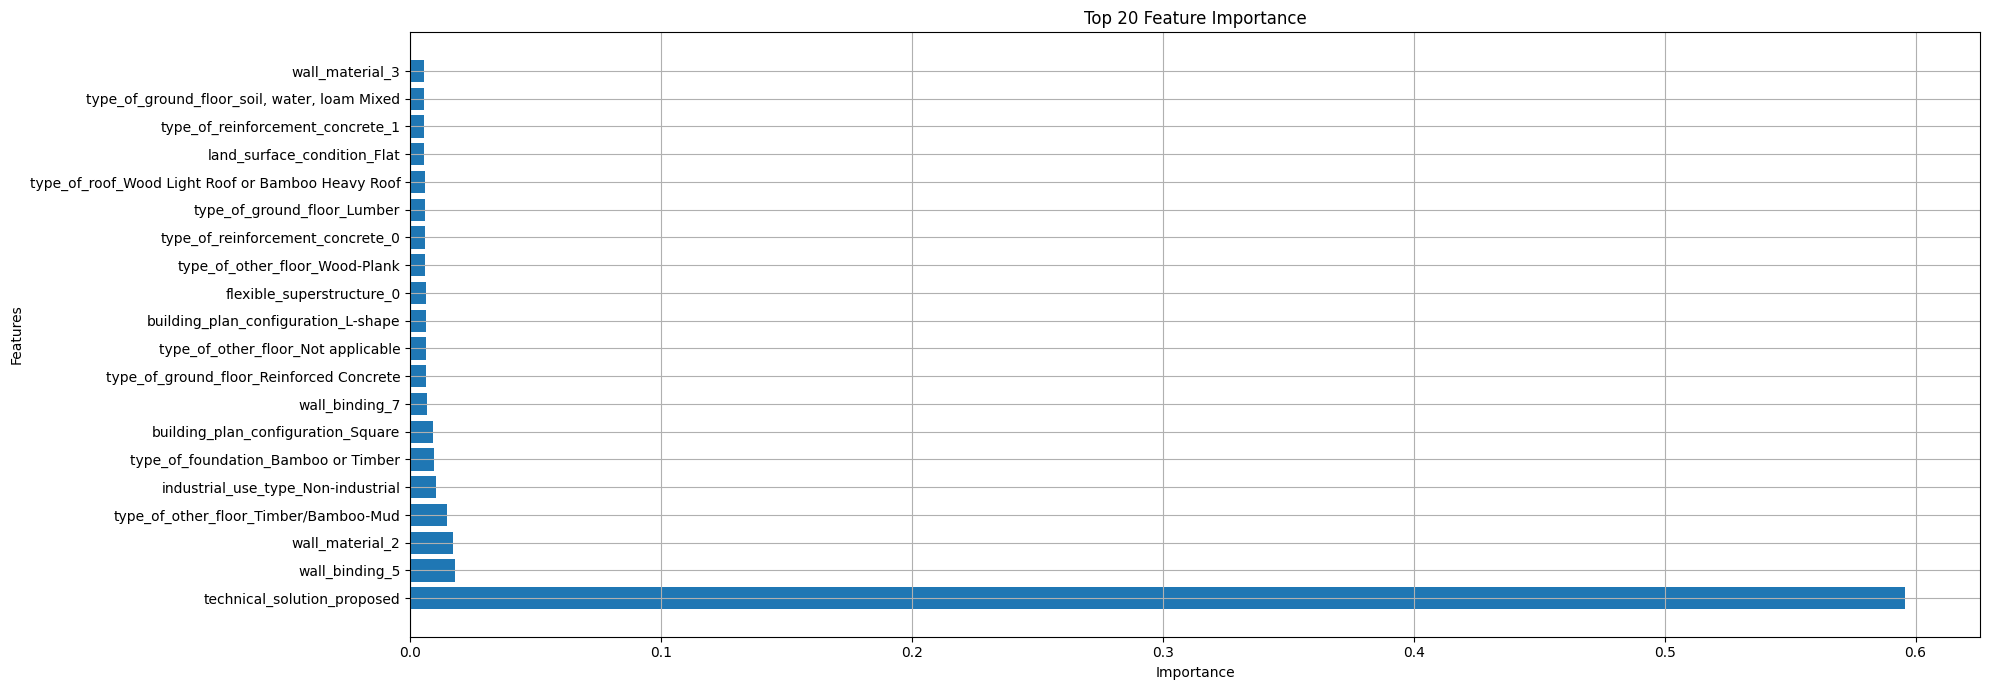

In [4]:
submission, top_20_features, top_20_normalized_importance = xgboost(train, test, ids)

In [7]:
submission.to_csv("Submissions/xgboost_log_fe_fillna_lessrow_lessunique_le_ohe.csv", index=False)

In [6]:
# Average F1 Score: 0.6543862857860724